### Bootstrappign AR models
1. Estimate $\hat{W}$
2. Calculate Residuals $\hat{\varepsilon}$
3. Use the DGP AR(1) with coefficient matrix $\hat{W}$, and residuals samples from $\{\hat{\varepsilon}\}$

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from timeit import default_timer as timer

import sys
sys.path.append("..")

import helper.helper as h
import helper.methods as m

from notears.notears.notears import utils 

from importlib import reload  # Python 3.4+
reload(m)
reload(h)

<module 'helper.helper' from '..\\helper\\helper.py'>

[[ 0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.8  0.   0.   0. ]
 [ 1.7 -1.2 -0.6  0.9  0.   0. ]
 [ 1.7  1.9  0.6  0.   0.9  0. ]
 [ 0.   0.  -1.2 -1.3  1.6  0. ]]


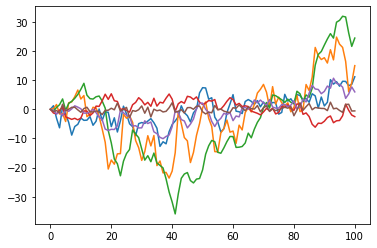

In [16]:
p, s, T = 6, 12, 101

A_true = h.generate_A(p, s)
X = h.generate_var_2(T, p, A_true, np.identity(p))

print(np.round(A_true, 1))
plt.plot(X)

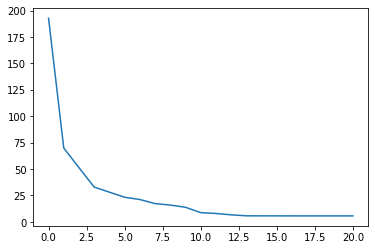

In [17]:
W_OMP, Ws, res = m._K_OMP_output(X[:-1], X[1:], normalize = True, is_sem = False, F = [], output = True, verbose = False)
residuals = X[1:] - X[:-1] @ W_OMP

plt.plot([h.MSE(W, X) for W in Ws])

In [18]:
def prediction_interval_W(Ws):
    
    means = np.mean(Ws, axis = 0)
    variances = np.zeros((p, p))
    
    for i in range(p):
        for j in range(p):
            variances[i][j] = np.cov(Ws[:, i, j])
    
    return means - 1.96 * variances, means + 1.96 * variances

for W in bootstrap_Ws[140:150]:
    print(np.round(W, 1))
    
W_1, W_2 = prediction_interval_W(np.array(Ws))
print(np.round(W_1, 3))
print(np.round(W_2, 3))

for i in range(p):
    for j in range(p):
        if W_1[i][j] < 0 and W_2[i][j] > 0:
            print(f"Edge ({i, j}) is considered unnecessary.")

[[-0.   0.   0.   0.   0.   0. ]
 [-1.9  0.9  0.   0.   0.1  0. ]
 [ 1.7  0.   0.1  0.   0.   0. ]
 [ 2.1 -0.2 -0.   0.1  0.   0. ]
 [ 0.   0.   0.   0.   0.8  0. ]
 [-0.2  1.8  0.   0.1 -0.1  0. ]]
[[ 0.   0.   0.   0.   0.   0. ]
 [-1.7  0.9  0.   0.   0.   0. ]
 [ 1.7  0.  -0.   0.   0.   0. ]
 [ 1.6  0.2  0.   0.1  0.   0. ]
 [ 0.2 -0.1 -0.   0.1  0.9  0. ]
 [ 0.1  1.7 -0.3 -0.1 -0.   0. ]]
[[ 0.   0.   0.   0.   0.   0. ]
 [-1.8  1.   0.   0.   0.   0. ]
 [ 1.5  0.   0.1  0.   0.   0. ]
 [ 2.1  0.   0.1 -0.1  0.   0. ]
 [-0.   0.  -0.1 -0.   0.9 -0.1]
 [ 0.2  1.7 -0.4 -0.1  0.   0.1]]
[[-0.   0.   0.   0.   0.   0. ]
 [-1.8  0.9  0.  -0.   0.   0. ]
 [ 1.4  0.1  0.2  0.1  0.   0.1]
 [ 1.6  0.   0.  -0.   0.   0. ]
 [ 0.  -0.2  0.   0.   0.9  0. ]
 [-0.1  1.7  0.  -0.1 -0.2  0.1]]
[[ 0.   0.   0.   0.   0.   0. ]
 [-1.7  0.9  0.   0.   0.   0. ]
 [ 1.7  0.1  0.2  0.  -0.1  0. ]
 [ 1.9  0.1  0.   0.   0.  -0.1]
 [-0.1  0.   0.   0.1  0.9  0.1]
 [ 0.   2.   0.   0.   0.   0. ]]
[[ 0.

0	4	9	14	19	23	28	33	38	42	47	52	57	61	66	71	76	80	85	90	95	

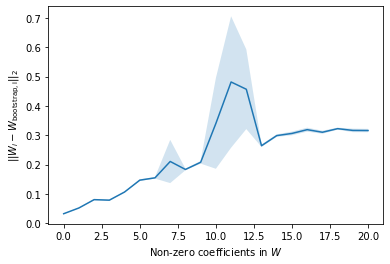

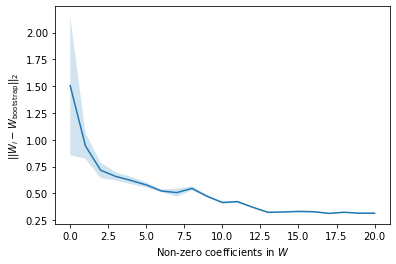

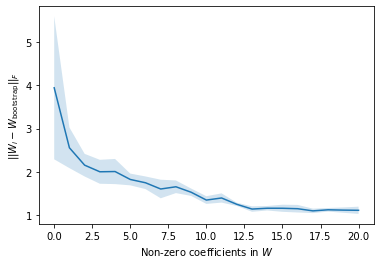

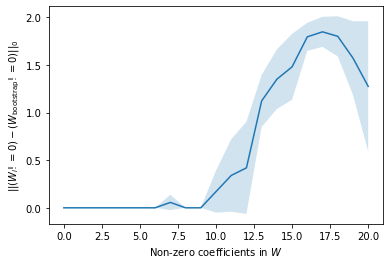

In [19]:
results = [[], [], [], []]
results_cov = [[], [], [], []]
bootstrap_Ws = []
iters = 25
for i, W in enumerate(Ws):
    print(i * 100 // len(Ws), end = "\t")
    # get residuals
    residuals = X[1:] - X[:-1] @ W
    
#     print(np.mean(residuals, axis = 0))
#     print(np.cov(residuals.T))
    
    residuals -= np.mean(residuals, axis = 0)
    R = np.shape(residuals)[0]

    # Initialize series
    results_i = [[], [], [], []]
    for j in range(iters):
        X_bootstrap = h.generate_var_res(T, W, residuals)
        W_bootstrap, Ws_bootstrap, _ = m._K_OMP_output(X_bootstrap[:-1], X_bootstrap[1:], normalize = True, is_sem = False, F = [], output = True, verbose = False)
        bootstrap_Ws.append(W_bootstrap)
#         print(np.linalg.norm(W - Ws_bootstrap[i]))
        results_i[0].append(np.linalg.norm(W - Ws_bootstrap[i]))
        results_i[1].append(np.linalg.norm(W - W_bootstrap, 'f'))
        results_i[2].append(np.linalg.norm((W - W_bootstrap).flatten(), 1))
#         results_i[2].append(np.linalg.norm((W != 0) ^ (Ws_bootstrap[i] != 0)))
        results_i[3].append(np.linalg.norm((W > 0) ^ (Ws_bootstrap[i] > 0) + (W < 0) ^ (Ws_bootstrap[i]< 0)))
        
    results[0].append(sum(results_i[0]) / len(results_i[0]))
    results[1].append(sum(results_i[1]) / len(results_i[1]))
    results[2].append(sum(results_i[2]) / len(results_i[2]))
    results[3].append(sum(results_i[3]) / len(results_i[3]))
    
    results_cov[0].append(np.cov(np.array(results_i[0])))
    results_cov[1].append(np.cov(np.array(results_i[1])))
    results_cov[2].append(np.cov(np.array(results_i[2])))
    results_cov[3].append(np.cov(np.array(results_i[3])))

plt.xlabel("Non-zero coefficients in $W$")
plt.ylabel(r'||$W_i - W_{\mathrm{bootstrap, i}}||_2$')
plt.plot(results[0])
plt.fill_between(range(len(results[0])), np.array(results[0]) - 1 * np.array(results_cov[0]), np.array(results[0]) + 1 * np.array(results_cov[0]), alpha = 0.2)
plt.show()

plt.plot(results[1])
plt.xlabel("Non-zero coefficients in $W$")
plt.ylabel(r"$|| W_i - W_{\mathrm{bootstrap}} ||_2$")
plt.fill_between(range(len(results[1])), np.array(results[1]) - 1 * np.array(results_cov[1]), np.array(results[1]) + 1 * np.array(results_cov[1]), alpha = 0.2)
plt.show()

plt.plot(results[2])
plt.xlabel("Non-zero coefficients in $W$")
plt.ylabel(r"$|| W_i - W_{\mathrm{bootstrap}} ||_F$")
plt.fill_between(range(len(results[2])), np.array(results[2]) - 1 * np.array(results_cov[2]), np.array(results[2]) + 1 * np.array(results_cov[2]), alpha = 0.2)
plt.show()

plt.plot(results[3])
plt.xlabel("Non-zero coefficients in $W$")
plt.ylabel(r"$|| (W_i != 0) - (W_{\mathrm{bootstrap}} != 0) ||_0$")
plt.fill_between(range(len(results[3])), np.array(results[3]) - 1 * np.array(results_cov[3]), np.array(results[3]) + 1 * np.array(results_cov[3]), alpha = 0.2)
plt.show()

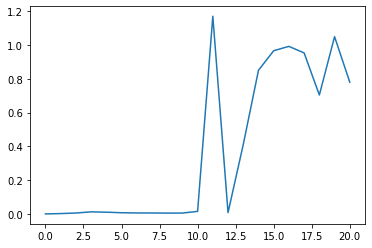

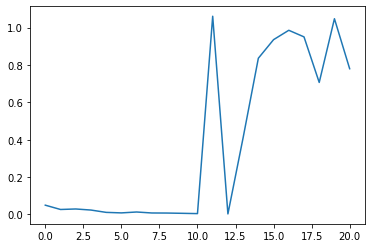

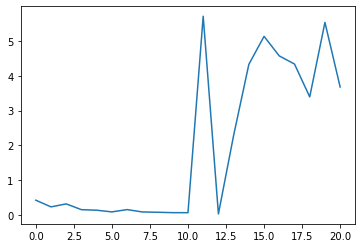

In [11]:
plt.plot(results_cov[0])
plt.show()

plt.plot(results_cov[1])
plt.show()

plt.plot(results_cov[2])
plt.show()

NameError: name 'two_fold_mses' is not defined

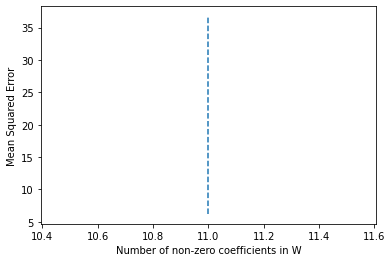

In [12]:
covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(A_true.T, A_true.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))

def expected_cost_var(W_true, W_est, Sigma = np.identity(p)):
    
    # base on the distribution of X, no actual data needed.    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W_true.T, W_true.T)), Sigma.reshape(p ** 2)).reshape((p, p))
    
    # covariance matrix
    covariance_matrix = Sigma + np.matmul((W_true - W_est).T, np.matmul(covariance_X.T, (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

l_lim = 3
plt.xlabel("Number of non-zero coefficients in W")
plt.ylabel("Mean Squared Error")
exp_cost = [expected_cost_var(A_true, W) for W in Ws[l_lim:]]
plt.vlines(l_lim + np.argmin(exp_cost), min(exp_cost), max(exp_cost), linestyle = '--')
plt.vlines(np.argmin(np.mean(np.array(two_fold_mses), axis = 0)) + 0.1, min(exp_cost), max(exp_cost), linestyle = '--', color = 'orange')
plt.vlines(np.argmin(np.mean(np.array(more_fold_mses), axis = 0)) - 0.1, min(exp_cost), max(exp_cost), linestyle = '--', color = 'green')
plt.plot(range(l_lim + 1, l_lim + len(exp_cost) + 1), exp_cost, label = "True Risk")
plt.plot(range(l_lim + 1, np.shape(two_fold_mses)[1] + 1), np.mean(np.array(two_fold_mses), axis = 0)[l_lim:], label = f"2-Fold")
plt.plot(range(l_lim + 1, np.shape(more_fold_mses)[1] + 1), np.mean(np.array(more_fold_mses), axis = 0)[l_lim:], label = f"{num_splits}-Fold")

plt.legend()

In [ ]:
def k_fold_cross_validation(num_splits):
    mses_avg = []
    
    # for each split
    for i in range(num_splits):
        
        # get numbers to remove
        k = range(i * T // num_splits, min((i + 1) * T // num_splits, T - 1))
        print(f"Remove X-Y pairs {k[0]} until {k[-1]}.", end = "\t")
        
        # if length 2, delete, do OMP, remove
        if len(k) >= 2:
            atoms_del = np.delete(atoms, k, axis = 1)
            residuals_del = np.delete(residuals, k, axis = 1)
            W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y.T, y) for y in residuals_del], atoms_del, normalize = True, F = [], tol = -0.99)
    
            mses_avg.append([1 / (len(k)) * np.linalg.norm(X[k[1:]] - X[k[:-1]] @ W, 'f') ** 2 for W in Ws])

        elif len(k) == 1 and k[0] > 0:
            atoms_del = np.delete(atoms, k, axis = 1)
            residuals_del = np.delete(residuals, k, axis = 1)
            W, Ws, _ = K_OMP(atoms_del.dot(atoms_del.T), atoms_del.dot(residuals_del.T), [np.dot(y.T, y) for y in residuals_del], atoms_del, normalize = True, F = [], tol = -0.99)
    
            mses_avg.append([np.linalg.norm(X[k[0] + 1] - X[k[0]] @ W, 2) ** 2 for W in Ws])
            # print(round(np.linalg.norm(X[k[1:]] - X[k[:-1]] @ W, 2) ** 2), end = "\t")
    
    return mses_avg

atoms = np.array([X[:-1, i] for i in range(p)])
residuals = np.array([X[1:, j] for j in range(p)])

num_splits = T - 1
two_fold_mses = k_fold_cross_validation(2)
more_fold_mses = k_fold_cross_validation(num_splits)

print(np.shape(two_fold_mses), np.shape(more_fold_mses))
# plot results
plt.vlines(np.argmin(np.mean(np.array(two_fold_mses), axis = 0)), min(np.mean(np.array(two_fold_mses), axis = 0)) - 1, max(np.mean(np.array(two_fold_mses), axis = 0)), linestyle = "--")
plt.plot(np.mean(np.array(two_fold_mses), axis = 0), label = "2-Folds")

plt.vlines(np.argmin(np.mean(np.array(more_fold_mses), axis = 0)), min(np.mean(np.array(more_fold_mses), axis = 0)) - 1, max(np.mean(np.array(more_fold_mses), axis = 0)), linestyle = "--", color = "orange")
plt.plot(np.mean(np.array(more_fold_mses), axis = 0), label = f"{num_splits}-Fold")
plt.legend()

In [13]:
def K_OMP(Psi, K, Theta, X, max_coefs = 1e10, tol = 0.0, tol_res = 0.0, verbose = False, output = False, normalize = False, F = [], is_sem = False):
    """Do Kernel OMP on X, Y."""

    def Lambda_to_adj(Lambda):
        """Convert Lambda list to adjacency matrix"""
        n = len(Lambda)
    
        adj_mat = np.zeros((n, n))
    
        for i, col in enumerate(Lambda):
            adj_mat[i, col] = 1 
    
        return adj_mat
    
    # get dimensions
    n = np.shape(Psi)[0]

    if is_sem: F = [i * (n + 1) for i in range(n)]
    
    # initialize Lambda, idx, betas
    Lambda, idx, betas, Ws = [[] for _ in range(n)], [], np.zeros((n, n)), []
    
    # compute norms if we want to normalize
    norms = [1] * n # initialize as harmless 1 array
    if normalize: norms = [np.linalg.norm(x) for x in X]

    # for each possible coefficient
    for i in range(n ** 2):    
    
        # compute gains
        gains = np.abs([(k - betas.T @ Psi[i, :]) / norms[i] for i, k in enumerate(K)])
        # set forbidden set to -1, impossible to pick then
        gains = gains.flatten()
        
        gains[F] = - np.ones(len(F))
        gains = gains.reshape(n, n)
        # stopping criterion
        # print(np.round(gains.max(), 1), end = "\t")
        if np.round(gains, 8).max() <= tol: 
            break

        # append best atom to Lambda
        # if tie, pick the one that minimizes residual
        row, col = np.argmax(gains) // n, np.argmax(gains) % n

        if row not in Lambda[col]: Lambda[col].append(row)
        else: print("A")
    
        # check if we have a DAG, not super efficient
        if h.is_dag(Lambda_to_adj(Lambda)): 
            # update only column col, use indices of 
            idx = Lambda[col]
            Psi_F = Psi[np.array(idx)[:, None], np.array(idx)[None, :]]
        
            # speedup: add transpose to forbidden set
            F.append(col * n + row)
            F.append(row * n + col)
            
            # update betas
            betas[np.array(idx)[:, None], col] = np.linalg.pinv(Psi_F) @ K[np.array(idx)[:, None], col]
            
            Ws.append(betas.copy())
            
            # print(np.round(betas[row][col], 1), end = "\t")
            # if np.abs(betas[row][col]) <= tol: break
            if len(np.nonzero(betas)[0]) >= max_coefs: break
            
        else:
            # append forbidden entry to forbidden list
            F.append(int(np.argmax(gains)))
            # remove coefficient from Lambda
            Lambda[col].remove(row)
    
#         # check residual squared
#         print(sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]))
#         print(row, col)

        if sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)]) < tol_res:
            print("Residual Limit, terminate")
            break

        # print info if verbose
        if verbose:
            print(f"Iteration {i + 1}.\n")
            print(f"Gains:\n{np.round(gains, 3)}.\n")
            print(f"Beta_{i + 1}:\n{np.round(betas, 3)}.\n")
            print(f"Residual Squared: {np.round([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)], 32)}.\n\n")

    return betas, Ws, sum([Theta[i] - K[:, i] @ betas[:, i] for i in range(n)])
